In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
import kvn
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

24252
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [85]:
# -----------------------------------------------------------
# --- LCHS parameters ---
# get_Rc_angles
# -----------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

# --- rr is computed by comparing simulations with and without AA ---
beta_, sign_ = 0.700, -1

# k_max_, nk_, rr_        = 10.0,   5,  4.987032727149e+00
# k_max_, nk_, rr_        = 10.0,   7,  1.009392172023e+01
# k_max_, nk_, rr_        = 10.0,   9,  2.024974348049e+01
# k_max_, nk_, rr_, sign_ = 20.0,   8,  1.401957690537e+01,   1
# k_max_, nk_, rr_, sign_ = 160.0, 11,  3.959684676225e+01,   1
# k_max_, nk_, rr_        = 100.0,  9,  1.980775248126e+01


# k_max_, nk_, rr_        = 40.0,   7,  9.896357602441e+00
# k_max_, nk_, rr_, sign_ = 40.0,   8,  1.397503280957e+01,   1
# k_max_, nk_, rr_        = 40.0,   9,  1.981270195959e+01
# k_max_, nk_, rr_        = 40.0,   10,  2.800181982885e+01
# k_max_, nk_, rr_, sign_ = 40.0,   11,  3.960666927518e+01,   1
# k_max_, nk_, rr_        = 40.0,   12,  5.603030858981e+01


# k_max_, nk_, rr_        = 80.0,  7,  1.003005883646e+01
# k_max_, nk_, rr_, sign_ = 80.0,  8,  1.397761275106e+01,   1
# k_max_, nk_, rr_        = 80.0,  9,  1.980767542286e+01
# k_max_, nk_, rr_        = 80.0,  10,  2.799503405685e+01
# k_max_, nk_, rr_, sign_ = 80.0,  11,  3.959700078398e+01,   1
k_max_, nk_, rr_        = 80.0,  12,  5.601634647580e+01


# --- Fourier k-grid ---
Nk_ = 1 << nk_
dk_ = 2.* k_max_ / (Nk_ - 1)

arr_theta_ = np.linspace(-np.pi/2., np.pi/2., Nk_)
d_theta_ = np.diff(arr_theta_)[0]
k_ = k_max_ * np.sin(arr_theta_)

print("nk:\t {:d}".format(nk_))
print("dk:\t {:0.12e}".format(dk_))
print("kmax\t {:0.12f}".format(k_max_))
print("beta\t {:0.3f}".format(beta_))

# --- get LCHS weights ---
w_ = kvn.comp_LCHS_weights_OPT(k_max_, Nk_, beta_)
w_sqrt_ = np.sqrt(w_)

nk:	 12
dk:	 3.907203907204e-02
kmax	 80.000000000000
beta	 0.700


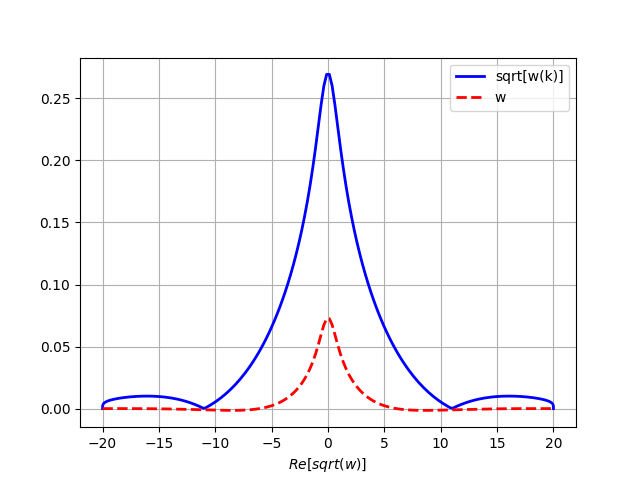

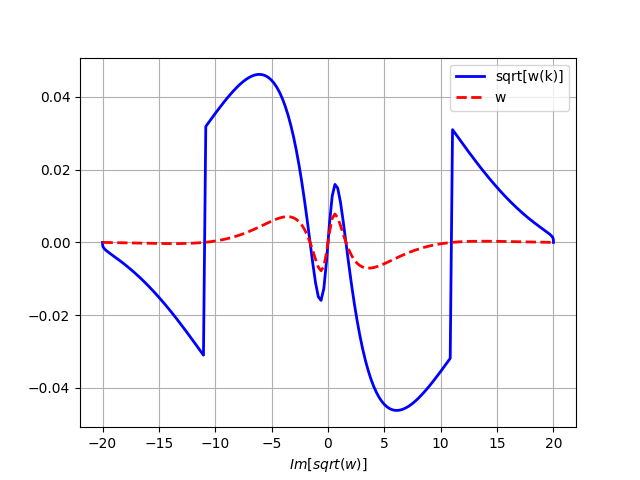

In [4]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)
def plot_weights(flag_save):

    y_plot = w_sqrt_
    # y_plot = w_sqrt_ * np.conjugate(w_sqrt_)
    # y_plot = w_sqrt_ * w_sqrt_



    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k_, y_plot.real, 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    ax.plot(
        k_, w_.real, 
        color='r', linewidth = 2, linestyle='--',  label = "w"
    )
    plt.xlabel('$x$')
    plt.xlabel('$Re[sqrt(w)]$')
    ax.legend()
    plt.grid(True)
    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k_, y_plot.imag, 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    ax.plot(
        k_, w_.imag, 
        color='r', linewidth = 2, linestyle='--',  label = "w"
    )
    plt.xlabel('$x$')
    plt.xlabel('$Im[sqrt(w)]$')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # --- Save the data ---
    if flag_save:  
        fname = "weights_sqrt_profs_k{:d}_b{:0.2f}".format(k_max_, beta_)     
        full_name = path_save_ + "/" + fname + "_RE.dat"
        mix.save_dat_plot_1d_file(full_name, arr_theta_, w_sqrt_.real)

        full_name = path_save_ + "/" + fname + "_IM.dat"
        mix.save_dat_plot_1d_file(full_name, arr_theta_, w_sqrt_.imag)
    return
# ------------------------------------------------------------
plot_weights(flag_save = False)

Reading the file ../QuCF/simulations/LCHS/weights-OPT//test_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-23-2024 15:26:57


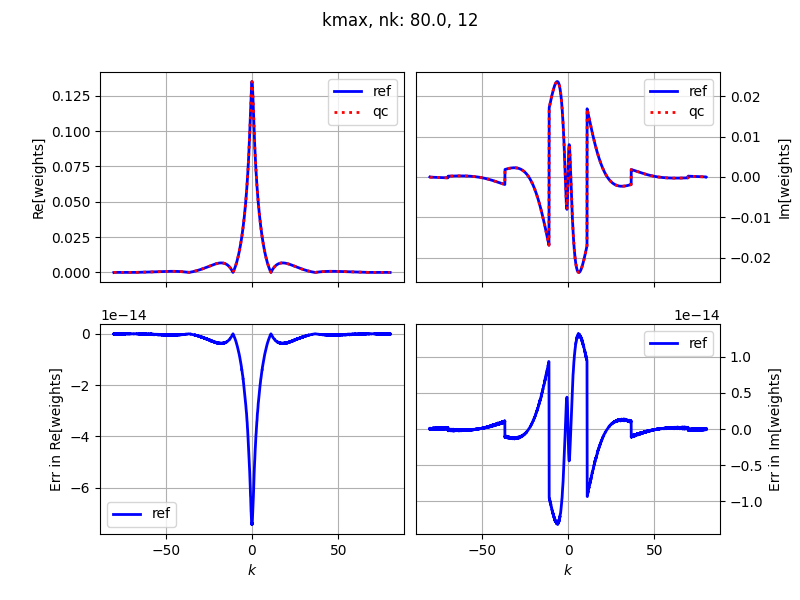

In [86]:
# -----------------------------------------------------------------
# --- QuCF computation of the LCHS weights ---
# -----------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
def QuCF_direct(flag_AA):
    # > When AA is included, keep flag_AA = False, 
    #   to find the amplitude of the amplified signal to compute rr
    # > Set flag_AA = True, when AA is included in QuCF simulations and 
    #   when rr has already been found
    
    y_ref = np.array(w_sqrt_)
    # y_ref = np.conjugate(y_ref)
    # y_ref = np.array(w_)

    Hadamart_norm_factor = 2**(nk_/2)

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/weights-OPT/"
    om.pname_ = "test"
    om.open()
    Ngates = om.dd_["N-gates"]

    om.set_zero_ancillae_work_states(0)
    y_qc = om.get_var_x({}, "rk")

    succ_prob = np.sum(np.abs(y_qc)**2)
    max_ampl = np.max(np.abs(y_qc))

    # --- renormalization ---
    y_qc *= Hadamart_norm_factor
    if flag_AA:
        # y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)
        # y_qc = y_qc / rr_
        y_qc = sign_ * y_qc / rr_  # here, the first order is used
            # in LCHS, rr_**2 should be used (two oracles for weight computation is used there)

    # --- Plotting results ---
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(8, 6)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0.04)

    axs[0][0].plot(k_, y_ref.real, '-b', linewidth = 2, label = "ref")
    axs[0][0].plot(k_, y_qc.real,  ':r', linewidth = 2, label = "qc")
    axs[0][0].set(ylabel="Re[weights]")
    axs[0][0].legend()
    axs[0][0].grid(True)
    axs[0][0].get_xaxis().set_ticklabels([])

    axs[1][0].plot(k_, y_qc.real - y_ref.real, '-b', linewidth = 2, label = "ref")
    axs[1][0].set(xlabel='$k$', ylabel="Err in Re[weights]")
    axs[1][0].legend()
    axs[1][0].grid(True)
    
    axs[0][1].plot(k_, y_ref.imag, '-b', linewidth = 2, label = "ref")
    axs[0][1].plot(k_, y_qc.imag,  ':r', linewidth = 2, label = "qc")
    axs[0][1].set(ylabel="Im[weights]")
    axs[0][1].legend()
    axs[0][1].grid(True)
    axs[0][1].yaxis.set_label_position("right")
    axs[0][1].yaxis.tick_right()
    axs[0][1].get_xaxis().set_ticklabels([])

    axs[1][1].plot(k_, y_qc.imag - y_ref.imag, '-b', linewidth = 2, label = "ref")
    axs[1][1].set(xlabel='$k$', ylabel="Err in Im[weights]")
    axs[1][1].legend()
    axs[1][1].grid(True)
    axs[1][1].yaxis.set_label_position("right")
    axs[1][1].yaxis.tick_right()

    fig.suptitle("kmax, nk: {:0.1f}, {:d}".format(k_max_, nk_))
    plt.show()

    # --- Print some resulting parameters ---
    print()
    if not flag_AA:
        print("A-max (before renorm.): {:0.12e}".format(max_ampl))
        print("success prob. (before renorm.): {:0.12e}".format(succ_prob))
        print()
        print("N-gates: {:d}".format(Ngates))
    return
# ----------------------------------------------------------------------
QuCF_direct(flag_AA = True)

In [84]:
# ----------------------------------------------------------
# --- Amplitude amplification of sqrt(weights) ---
# ----------------------------------------------------------
def print_rr(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------
# *** Here, succ_prob is a non-amplified success probability. ***
def print_NA(line_str, succ_prob):
    theta_AA = np.arcsin(np.sqrt(succ_prob))
    N_AA = int(0.5 * (np.pi/(2.*theta_AA) - 1.))  # +/- 1
    print("{:s}:\t N_AA {:d}".format(line_str, N_AA))
    return
# -----------------------------------------
def compute_AA_Dir_k80():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 80,  nk = 7",  5.492978547650e-01, 5.476516775439e-02)
    print_rr("kmax = 80,  nk = 8",  4.424234569931e-01, 3.165229033545e-02)
    print_rr("kmax = 80,  nk = 9",  3.287704436875e-01, 1.659813363602e-02)
    print_rr("kmax = 80,  nk = 10", 2.353225905368e-01, 8.405869057308e-03)
    print_rr("kmax = 80,  nk = 11", 1.669489023171e-01, 4.216200697318e-03)
    print_rr("kmax = 80,  nk = 12", 1.181744700442e-01, 2.109642586120e-03)

    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 80,  nk = 7", 9.880890787980e-03)
    print_NA("kmax = 80,  nk = 8", 5.092716428966e-03)
    print_NA("kmax = 80,  nk = 9", 2.548717357976e-03)
    print_NA("kmax = 80,  nk = 10", 1.274360075294e-03)
    print_NA("kmax = 80,  nk = 11", 6.371800376713e-04)
    print_NA("kmax = 80,  nk = 12", 3.185900188385e-04)

    return
# -----------------------------------------
def compute_AA_Dir_k40():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 40,  nk =  7", 4.436401845631e-01, 4.482863315829e-02)
    print_rr("kmax = 40,  nk =  8", 3.283370358441e-01, 2.349454490148e-02)
    print_rr("kmax = 40,  nk =  9", 2.356400466278e-01, 1.189338269502e-02)
    print_rr("kmax = 40,  nk = 10", 1.670044190204e-01, 5.964055909265e-03)
    print_rr("kmax = 40,  nk = 11", 1.181803111384e-01, 2.983848763381e-03)
    print_rr("kmax = 40,  nk = 12", 8.360064661345e-02, 1.492061149002e-03)

    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 40,  nk =  7", 1.017994132003e-02)
    print_NA("kmax = 40,  nk =  8", 5.094821062404e-03)
    print_NA("kmax = 40,  nk =  9", 2.547413460272e-03)
    print_NA("kmax = 40,  nk = 10", 1.273706737621e-03)
    print_NA("kmax = 40,  nk = 11", 6.368533697436e-04)
    print_NA("kmax = 40,  nk = 12", 3.184266849883e-04)
    return
# -----------------------------------------
def compute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,  nk =  5", 4.509140718992e-01, 9.041730755935e-02)
    print_rr("kmax = 10,  nk =  7", 2.407882108182e-01, 2.385477295070e-02)
    print_rr("kmax = 10,  nk =  9", 1.209326248815e-01, 5.972057127441e-03)
    print_rr("kmax = 20,  nk =  8", 2.360314611587e-01, 1.683584766872e-02)
    print_rr("kmax = 100, nk =  9", 3.640610080762e-01, 1.837972321295e-02)
    print_rr("kmax = 160, nk = 11", 2.353012421820e-01, 5.942423738809e-03)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,  nk =  5", 3.890587488107e-02)
    print_NA("kmax = 10,  nk =  7", 9.738781664262e-03)
    print_NA("kmax = 10,  nk =  9", 2.434706684172e-03)
    print_NA("kmax = 20,  nk =  8", 5.058512304123e-03)
    print_NA("kmax = 100, nk =  9", 2.548697367493e-03)
    print_NA("kmax = 160, nk = 11", 6.371852419263e-04)
    return
# -----------------------------------------
print("REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.\n")
# compute_AA_Dir()
# compute_AA_Dir_k40()
compute_AA_Dir_k80()

REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.

kmax = 80,  nk = 7:	 rr = 1.003005883646e+01
kmax = 80,  nk = 8:	 rr = 1.397761275106e+01
kmax = 80,  nk = 9:	 rr = 1.980767542286e+01
kmax = 80,  nk = 10:	 rr = 2.799503405685e+01
kmax = 80,  nk = 11:	 rr = 3.959700078398e+01
kmax = 80,  nk = 12:	 rr = 5.601634647580e+01

kmax = 80,  nk = 7:	 N_AA 7
kmax = 80,  nk = 8:	 N_AA 10
kmax = 80,  nk = 9:	 N_AA 15
kmax = 80,  nk = 10:	 N_AA 21
kmax = 80,  nk = 11:	 N_AA 30
kmax = 80,  nk = 12:	 N_AA 43


In [29]:
print("{:0.12e}".format(1.189338269502e-02/5.964055909265e-03))

1.994176928580e+00


In [ ]:
def copmute_AA_Dir_k40():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 40,  nk =  9", 2.356400466278e-01, 1.189338269502e-02)


    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print_NA("kmax = 40,  nk =  9", 2.547413460272e-03)

    return
# -----------------------------------------
def copmute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,  nk =  5", 4.509140718992e-01, 9.041730755935e-02)
    print_rr("kmax = 10,  nk =  7", 2.407882108182e-01, 2.385477295070e-02)
    print_rr("kmax = 10,  nk =  9", 1.209326248815e-01, 5.972057127441e-03)
    print_rr("kmax = 20,  nk =  8", 2.360314611587e-01, 1.683584766872e-02)
    print_rr("kmax = 80,  nk = 10", 2.353225905368e-01, 8.405869057308e-03)
    print_rr("kmax = 100, nk =  9", 3.640610080762e-01, 1.837972321295e-02)
    print_rr("kmax = 160, nk = 11", 2.353012421820e-01, 5.942423738809e-03)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,  nk =  5", 3.890587488107e-02)
    print_NA("kmax = 10,  nk =  7", 9.738781664262e-03)
    print_NA("kmax = 10,  nk =  9", 2.434706684172e-03)
    print_NA("kmax = 20,  nk =  8", 5.058512304123e-03)
    print_NA("kmax = 80,  nk = 10", 1.274360075294e-03)
    print_NA("kmax = 100, nk =  9", 2.548697367493e-03)
    print_NA("kmax = 160, nk = 11", 6.371852419263e-04)
    return